In [27]:
import os
import seaborn as sns
import re
from collections import Counter
from hazm import *
import random
normalizer = Normalizer()

from typing import List
import matplotlib.pyplot as plt

from tqdm import tqdm

import arabic_reshaper
from bidi.algorithm import get_display


In [5]:
convs_dir_path = "/Users/choobani/Downloads/ninisite-crawler/dialogue"
convs_paths = os.listdir(convs_dir_path)

convs = []
for path in convs_paths:
    with open(f'{convs_dir_path}/{path}') as jsonl:
        conv = jsonl.readlines()
        for c in conv:
            convs.append(c.strip())

In [6]:
convs = list(set(convs))
print(len(convs))

1273063


In [7]:
# convs = random.choices(convs, k=10000)

In [8]:
questions = [" ".join(eval(conv)['question']) if type(eval(conv)['question'])==list else eval(conv)['question'] for conv in convs ]
answers = [" ".join(eval(conv)['answer']) if type(eval(conv)['answer'])==list else eval(conv)['answer'] for conv in convs ]
topics = [eval(conv)['topic'] for conv in convs]
assert len(questions) == len(answers) == len(topics)

In [9]:
def clean_text(s):
    s = s.replace("\u200c", "")
    s = s.replace("\u200d", "")
    s = re.sub(r'[a-zA-Z0-9.:@#[$%^&*()}{\]_+-=±]', '', s)
    s = s.strip()
    s = normalizer.normalize(s)
    return s

In [10]:
questions = [clean_text(q) for q in questions]
answers = [clean_text(a) for a in answers]
topics = [clean_text(t) for t in topics]
assert len(questions) == len(answers) == len(topics)

In [11]:
questions_topics_merged = []
for c in zip(topics, questions):
    questions_topics_merged.append(c[0]+" "+c[1])
assert len(questions_topics_merged) == len(answers)

In [12]:
questions_char_len = [len(q) for q in questions_topics_merged if len(q) < 1000]
answers_char_len = [len(a) for a in answers if len(a) < 1000]

<AxesSubplot:ylabel='Count'>

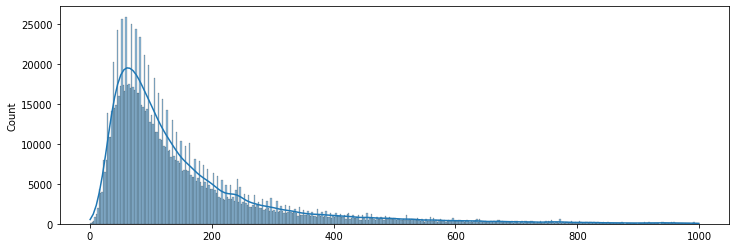

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(questions_char_len, kde=True)

<AxesSubplot:ylabel='Count'>

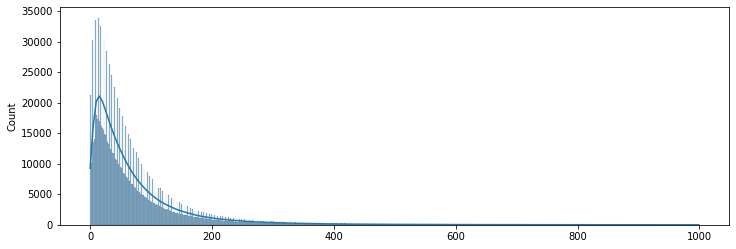

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(answers_char_len, kde=True)

In [15]:
pairs = []
for q,a in zip(questions_topics_merged, answers):
    if a != '':
        pairs.append((q,a))
questions = [p[0] for p in pairs]
answers = [p[1] for p in pairs]

In [16]:
### word lengths
questions_word_count = [len(q.split(" ")) for q in questions if len(q) < 1000]
answers_word_count = [len(a.split(" ")) for a in answers if len(a) < 1000]

<AxesSubplot:ylabel='Count'>

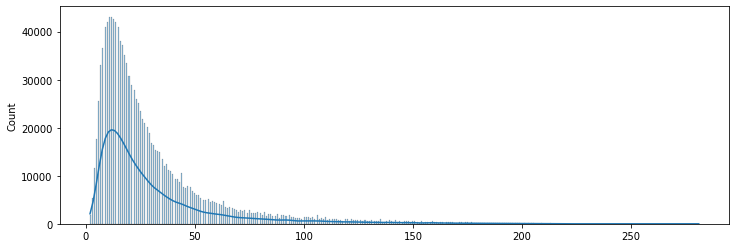

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(questions_word_count, kde=True)

<AxesSubplot:ylabel='Count'>

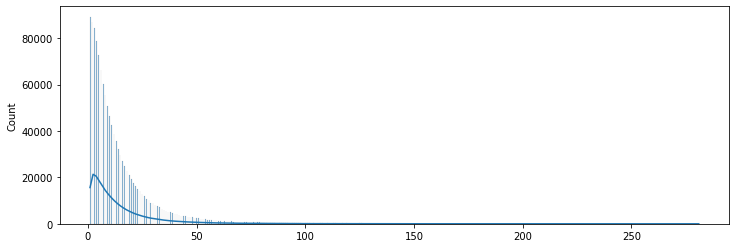

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(answers_word_count, kde=True)

In [19]:
import json
with open("cleaned_pairs", "w", encoding="utf-8") as f:
    for q,a in zip(questions, answers):
        json.dump({"question":q, "answer":a}, f, ensure_ascii=False)
        f.write("\n")

#### Insights from DIALOGPT paper
We filter the data by removing the instances where<br>(1) there is a URL in source or target<br>(2) where the target contains word repetitions of at least three words<br>(3) where the response does not contain at least one of the top-50 most frequent English words (e.g., “the”, “of”, “a”), since this probably indicates it might not be an English sentence<br>(4) where the response contains special markers such as “[” or “]”, as this could be markup. language<br>(5) where source and target sequences
together are longer than 200 words<br>(6) where the target contains offensive language, identified by phrase matching against a large blocklist. Wealso excluded a large number of subreddits that had been identified as likely to contain offensive content.<br>(7) we aggressively filtered outblandness, e.g., removing instances where the responses contained 90% of tri-grams that have been seen more than 1000 times. Often uninformative, such responses account for about 1% of the data.After filtering, the dataset comprises 147,116,725 dialogue instances, in total 1.8 billion words.

In [1]:
import json
with open("cleaned_pairs", "r") as f:
    pairs = f.readlines()


In [5]:
questions = [eval(p)['question'] for p in pairs]

In [6]:
answers = [eval(p)['answer'] for p in pairs]

In [7]:
pairs = None

In [8]:
## generate n-grams
def generate_ngrams(s, n):
    tokens = [token for token in s.split(" ") if token != ""]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [18]:
def get_top_ngrams(strings, n: int) -> dict:
    ngrams = [generate_ngrams(s, n) for s in tqdm(strings) if len(s) < 1000]
    flat_ngrams = [q for ql in ngrams for q in ql]
    flat_ngrams_count = Counter(flat_ngrams)
    flat_ngrams_count = {k: v for k, v in sorted(flat_ngrams_count.items(), key=lambda item: item[1], reverse=True)}
    return flat_ngrams_count

In [39]:
def get_plot_data(obj, n):
    x = [get_display(arabic_reshaper.reshape(str(i))) for i in list(obj.keys())[:n]]
    y = list(obj.values())[:n]
    all_y = sum(list(obj.values()))
    y_labels = [f"{i/all_y*100:.2f}%" for i in y]
    return x,y,y_labels

In [20]:
top_q_trigrams = get_top_ngrams(questions, 3)

100%|██████████| 1257449/1257449 [02:49<00:00, 7434.33it/s] 


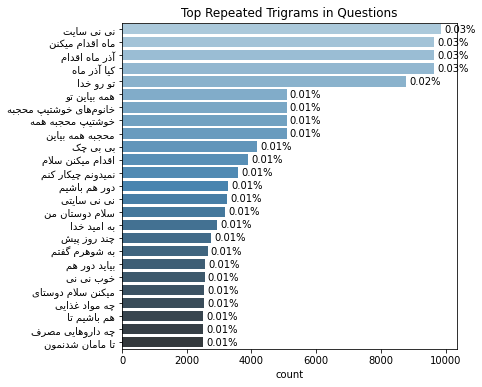

In [40]:
x,y,y_labels = get_plot_data(top_q_trigrams, 25)
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=y, y=x,palette="Blues_d").set(title='Top Repeated Trigrams in Questions', xlabel='count')
ax.bar_label(ax.containers[0], labels=y_labels, padding=3)
plt.show()


In [ ]:
top_a_trigrams = get_top_ngrams(answers, 3)

/Users/choobani/.pyenv/versions/3.9.0/envs/Pv9/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


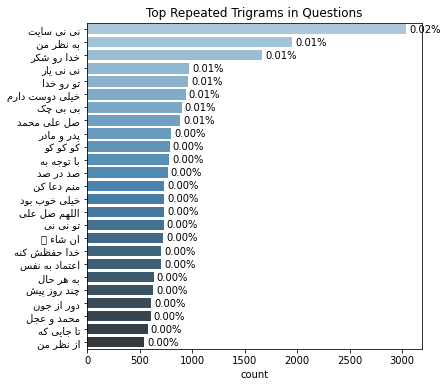

In [45]:

x,y,y_labels = get_plot_data(top_a_trigrams, 25)
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=y, y=x,palette="Blues_d").set(title='Top Repeated Trigrams in Questions', xlabel='count')
ax.bar_label(ax.containers[0], labels=y_labels, padding=3)
plt.show()
